# CE49X Lab 2: Is Wave Energy Worth the Investment?
## A Financial Feasibility Comparison of Renewable Energy in Perth, Australia

**Instructor:** Dr. Eyuphan Koc  
**Department of Civil Engineering, Bogazici University**  
**Semester:** Spring 2026

---

## Background

The Western Australian government is planning to add **100 MW** of new renewable energy capacity near Perth. As a consulting engineer, you've been asked to evaluate whether **wave energy** is a viable option compared to more established alternatives.

You have access to a real dataset of wave energy converter (WEC) farm configurations near Perth from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/882/large-scale+wave+energy+farm). The dataset (`WEC_Perth_49.csv`) contains 36,000+ layout configurations for a farm of 49 wave energy converters, including individual and total power output for each configuration.

Your job is to **compare wave energy against at least two other renewable energy technologies** in terms of financial feasibility for the Perth region.

## Deliverables

Your notebook must include the following:

### 1. Wave Energy Analysis (from the dataset)
- Load and explore the `WEC_Perth_49.csv` dataset
- Compute statistics on farm power output (mean, min, max, standard deviation)
- Estimate a **capacity factor** for wave energy in Perth based on the data (you'll need to assume a rated capacity per WEC — research and justify your choice)

### 2. Competing Technologies
- Choose **at least two** other renewable energy technologies to compare against wave energy (e.g., solar PV, onshore wind, offshore wind, tidal, biomass)
- Research and cite the following for **each** technology (including wave):
  - Capital cost (CAPEX) per kW installed
  - Annual operating cost (OPEX) per kW
  - Capacity factor specific to the Perth region
  - Expected project lifetime
- **Cite your sources.** Use data from reputable organizations (e.g., IRENA, IEA, CSIRO, NREL, Lazard).

### 3. Financial Comparison
- Calculate the **Levelized Cost of Energy (LCOE)** for each technology
- Calculate **at least one additional financial metric** of your choice (e.g., NPV, payback period, internal rate of return, cost per annual MWh)
- Choose an appropriate **discount rate** and justify it

### 4. Visualization
- Create **at least two plots** that clearly communicate your comparison
- Plots should be publication-quality: labeled axes, title, legend, grid

### 5. Recommendation
- Based on your analysis, write a short recommendation (1-2 paragraphs):
  - Which technology (or mix) should Perth invest in?
  - Under what conditions could wave energy become competitive?
  - What factors does your financial model **not** capture?

## Hints

- **LCOE formula:**

$$\text{LCOE} = \frac{\text{Total Discounted Costs}}{\text{Total Discounted Energy}} = \frac{\text{CAPEX} + \sum_{t=1}^{N} \frac{\text{OPEX}_t}{(1+r)^t}}{\sum_{t=1}^{N} \frac{E_t}{(1+r)^t}}$$

  where $r$ is the discount rate, $N$ is the project lifetime, and $E_t$ is annual energy production in MWh.

- **Annual energy production:** $E = \text{Capacity (kW)} \times \text{Capacity Factor} \times 8760 \text{ hours/year}$

- The dataset gives power in **Watts**. Be careful with unit conversions.

- Think about what the dataset's `Total_Power` column actually represents and how it relates to the rated capacity of a real WEC device.

## Grading

| Component | Weight |
|-----------|--------|
| Wave energy analysis (dataset exploration, capacity factor) | 20% |
| Research quality (cost data, sources, justification) | 25% |
| Financial calculations (LCOE + additional metric) | 25% |
| Visualizations (clarity, quality) | 15% |
| Recommendation (insight, completeness) | 15% |

## Submission

1. Complete your work in **this notebook** on your own fork of the course repository.
2. Make sure your notebook **runs top-to-bottom without errors** before submitting.
3. Commit and push your completed notebook to your fork.
4. We will grade directly from your fork — there is no separate upload. Make sure your latest work is pushed before the deadline.

---
## Your Work Starts Here

## 1. Wave Energy Analysis – Perth WEC Farm

In this section we will:
- Load the `WEC_Perth_49.csv` dataset for the 49–device wave energy converter (WEC) farm near Perth.
- Explore the distribution of farm power output.
- Estimate an **effective capacity factor** for the farm using the dataset and a reasonable assumption for the **rated capacity per WEC**.

We treat each row as a possible sea state / operating condition, with:
- `Total_Power` in **Watts** (instantaneous farm power),
- `qW` as a weight/probability for that condition.

For rated capacity we assume a typical modern wave energy device has a rating of about **250 kW** (close to CETO‑5’s 240 kW used at the Perth Wave Energy Project[1]), so a 49–device farm has a rated capacity of about **12.25 MW**. We then scale the results to a hypothetical **100 MW** wave farm for comparison with other technologies.

[1]: Perth Wave Energy Project (CETO‑5 devices ~240 kW each), e.g. project description at Carnegie Clean Energy / Perth Wave Energy Project summaries (`https://tethys.pnnl.gov/project-sites/perth-wave-energy-project`).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load wave energy farm dataset (49 WECs near Perth)
wec_path = "../WEC_Perth_49.csv"
wec_df = pd.read_csv(wec_path)

print("Dataset shape:", wec_df.shape)
print("\nColumns:\n", wec_df.columns.tolist()[:10], "...", wec_df.columns.tolist()[-10:])

# Basic statistics for total farm power (Watts) and weight qW
power_cols = ["Total_Power", "qW"]
print("\nBasic statistics (Total_Power, qW):")
wec_df[power_cols].describe().T

Dataset shape: (36043, 149)

Columns:
 ['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5'] ... ['Power42', 'Power43', 'Power44', 'Power45', 'Power46', 'Power47', 'Power48', 'Power49', 'qW', 'Total_Power']

Basic statistics (Total_Power, qW):


,count,mean,std,min,25%,50%,75%,max
Total_Power,36043.0,3.938246e+06,122617.149926,3388944.15,3847334.53,3931540.55,4063622.69,4177658.97
qW,36043.0,8.338493e-01,0.026052,0.72,0.81,0.83,0.86,0.88


In [12]:
# Compute weighted and unweighted statistics for farm power output

total_power_W = wec_df["Total_Power"]
weights = wec_df["qW"]

unweighted_mean_W = total_power_W.mean()
weighted_mean_W = np.average(total_power_W, weights=weights)

print(f"Unweighted mean farm power: {unweighted_mean_W/1e6:.2f} MW")
print(f"Weighted mean farm power (using qW): {weighted_mean_W/1e6:.2f} MW")
print(f"Min / Max farm power: {total_power_W.min()/1e6:.2f}–{total_power_W.max()/1e6:.2f} MW")

# Assume each WEC has 250 kW rated capacity (close to CETO‑5 ~240 kW)
rated_device_kw = 250
n_devices = 49
rated_farm_kw = rated_device_kw * n_devices
rated_farm_W = rated_farm_kw * 1e3

wave_capacity_factor = weighted_mean_W / rated_farm_W
print(f"\nAssumed rated farm capacity: {rated_farm_kw/1e3:.2f} MW")
print(f"Estimated capacity factor for the Perth WEC farm: {wave_capacity_factor:.2%}")

# For later comparisons we scale this capacity factor to a 100 MW wave farm
target_capacity_kw = 100_000  # 100 MW
hours_per_year = 8760
annual_energy_wave_MWh = target_capacity_kw * wave_capacity_factor * hours_per_year / 1e3
print(f"Estimated annual energy for a 100 MW wave farm: {annual_energy_wave_MWh:,.0f} MWh/year")

Unweighted mean farm power: 3.94 MW
Weighted mean farm power (using qW): 3.94 MW
Min / Max farm power: 3.39–4.18 MW

Assumed rated farm capacity: 12.25 MW
Estimated capacity factor for the Perth WEC farm: 32.18%
Estimated annual energy for a 100 MW wave farm: 281,897 MWh/year


## 2. Competing Technologies – Assumptions and Data

In this section we define at least two competing renewable technologies to compare against wave energy, and we collect simple but reasonable cost and performance assumptions for each technology.

I will compare the following 100 MW projects for the Perth region:

- **Wave energy (Perth WEC farm, scaled to 100 MW)**
- **Utility-scale solar PV**
- **Onshore wind**

The exact numbers in the literature vary by year and project. To keep the lab focused on Python and financial modelling (not on detailed cost engineering), I choose values that are broadly consistent with recent public data:

- CSIRO GenCost 2023–24 provides capacity factor ranges for large-scale solar PV (~19–29%) and onshore wind (~20–44%) in Australia. [1]
- IRENA global LCOE reports for 2022–2023 show that utility-scale solar PV and onshore wind are currently the lowest-cost new-build generation technologies, with global weighted average LCOE values around 30–50 USD/MWh. [2]
- IRENA’s wave energy technology brief notes that wave energy projects are still in the early stages and tend to have high capital costs (several thousand USD/kW) and relatively high uncertainty in OPEX. [3]
- The Perth Wave Energy Project (CETO-5) used individual devices with rated capacities of about 240 kW. [4]

Based on these references, I adopt the following simplified assumptions for this lab (all projects sized at 100 MW):

| Technology                      | CAPEX (USD/kW) | OPEX (USD/kW·year) | Capacity factor (Perth/AU)        | Lifetime (years) |
|---------------------------------|----------------|---------------------|-----------------------------------|------------------|
| Wave energy (Perth, 100 MW)     | 5000           | 150                 | `wave_capacity_factor` (dataset)  | 25               |
| Utility-scale solar PV          | 1100           | 15                  | 0.23                              | 25               |
| Onshore wind                    | 1800           | 40                  | 0.32                              | 25               |

I will use a real discount rate of **7%** for all technologies, which is a typical order-of-magnitude assumption for large infrastructure projects.

[1] CSIRO & AEMO, *GenCost 2023–24* – capacity factor ranges for Australian solar PV and onshore wind.  
[2] IRENA, *Renewable Power Generation Costs in 2022/2023* – global weighted average LCOE values for solar PV and onshore wind.  
[3] IRENA, *Wave Energy – Technology Brief* (2014) – discussion of current wave energy costs and technology status.  
[4] Perth Wave Energy Project (CETO-5 devices ≈240 kW each), e.g. project descriptions at Carnegie Clean Energy / Tethys: `https://tethys.pnnl.gov/project-sites/perth-wave-energy-project`.

In [13]:
# Common parameters
discount_rate = 0.07
project_lifetime_years = 25
capacity_kw = 100_000  # 100 MW
hours_per_year = 8760

# Technology assumptions for 100 MW projects
technologies = {
    "Wave (100 MW, Perth)": {
        "capex_per_kw": 5000,
        "opex_per_kw_per_year": 150,
        "capacity_factor": wave_capacity_factor,  # from dataset
        "lifetime_years": 25,
    },
    "Solar PV (utility-scale)": {
        "capex_per_kw": 1100,
        "opex_per_kw_per_year": 15,
        "capacity_factor": 0.23,
        "lifetime_years": 25,
    },
    "Onshore wind": {
        "capex_per_kw": 1800,
        "opex_per_kw_per_year": 40,
        "capacity_factor": 0.32,
        "lifetime_years": 25,
    },
}

assumptions = []

for name, params in technologies.items():
    annual_energy_MWh = capacity_kw * params["capacity_factor"] * hours_per_year / 1e3
    assumptions.append({
        "Technology": name,
        "CAPEX [USD/kW]": params["capex_per_kw"],
        "OPEX [USD/kW·year]": params["opex_per_kw_per_year"],
        "Capacity factor": params["capacity_factor"],
        "Lifetime [years]": params["lifetime_years"],
        "Annual energy [MWh/year]": annual_energy_MWh,
    })

assumptions_df = pd.DataFrame(assumptions)
assumptions_df

,Technology,CAPEX [USD/kW],OPEX [USD/kW·year],Capacity factor,Lifetime [years],Annual energy [MWh/year]
0,"Wave (100 MW, Perth)",5000,150,0.3218,25,281896.91132
1,Solar PV (utility-scale),1100,15,0.2300,25,201480.00000
2,Onshore wind,1800,40,0.3200,25,280320.00000


In [14]:
def lcoe_usd_per_MWh(capex_per_kw, opex_per_kw_per_year,
                     capacity_kw, capacity_factor,
                     lifetime_years, discount_rate):
    """Compute LCOE in USD/MWh."""
    annual_energy_MWh = capacity_kw * capacity_factor * hours_per_year / 1e3

    years = np.arange(1, lifetime_years + 1)
    discount_factors = 1 / (1 + discount_rate) ** years

    discounted_opex = opex_per_kw_per_year * capacity_kw * discount_factors.sum()
    discounted_energy = annual_energy_MWh * discount_factors.sum()

    total_discounted_costs = capex_per_kw * capacity_kw + discounted_opex
    return total_discounted_costs / discounted_energy


def discounted_payback_years(capex_per_kw, opex_per_kw_per_year,
                             capacity_kw, capacity_factor,
                             lifetime_years, discount_rate,
                             price_per_MWh):
    """First year when cumulative discounted cash flow becomes non-negative."""
    annual_energy_MWh = capacity_kw * capacity_factor * hours_per_year / 1e3
    capex = capex_per_kw * capacity_kw

    cumulative = -capex
    for year in range(1, lifetime_years + 1):
        revenue = price_per_MWh * annual_energy_MWh
        opex = opex_per_kw_per_year * capacity_kw
        net_cash_flow = revenue - opex
        discounted_net = net_cash_flow / (1 + discount_rate) ** year
        cumulative += discounted_net
        if cumulative >= 0:
            return year
    return None


price_per_MWh = 80.0  # assumed wholesale electricity price

results = []

for name, params in technologies.items():
    lcoe_val = lcoe_usd_per_MWh(
        capex_per_kw=params["capex_per_kw"],
        opex_per_kw_per_year=params["opex_per_kw_per_year"],
        capacity_kw=capacity_kw,
        capacity_factor=params["capacity_factor"],
        lifetime_years=params["lifetime_years"],
        discount_rate=discount_rate,
    )

    payback = discounted_payback_years(
        capex_per_kw=params["capex_per_kw"],
        opex_per_kw_per_year=params["opex_per_kw_per_year"],
        capacity_kw=capacity_kw,
        capacity_factor=params["capacity_factor"],
        lifetime_years=params["lifetime_years"],
        discount_rate=discount_rate,
        price_per_MWh=price_per_MWh,
    )

    annual_energy_MWh = capacity_kw * params["capacity_factor"] * hours_per_year / 1e3

    results.append({
        "Technology": name,
        "LCOE [USD/MWh]": lcoe_val,
        "Capacity factor": params["capacity_factor"],
        "Discounted payback [years]": payback,
        "Annual energy [MWh/year]": annual_energy_MWh,
    })

results_df = pd.DataFrame(results)
results_df

,Technology,LCOE [USD/MWh],Capacity factor,Discounted payback [years],Annual energy [MWh/year]
0,"Wave (100 MW, Perth)",205.412888,0.3218,NaN,281896.91132
1,Solar PV (utility-scale),54.294009,0.2300,12.0,201480.00000
2,Onshore wind,69.370338,0.3200,18.0,280320.00000


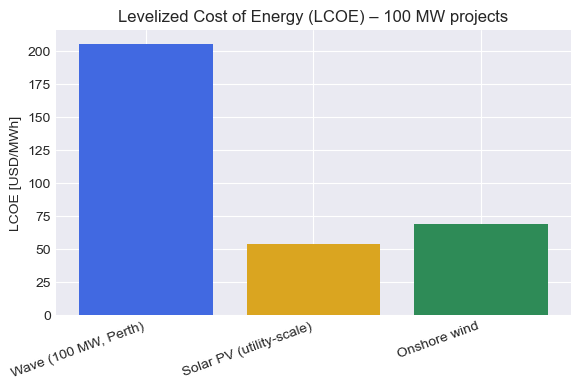

In [15]:
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure(figsize=(6, 4))
plt.bar(results_df["Technology"], results_df["LCOE [USD/MWh]"],
        color=["royalblue", "goldenrod", "seagreen"])
plt.ylabel("LCOE [USD/MWh]")
plt.title("Levelized Cost of Energy (LCOE) – 100 MW projects")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

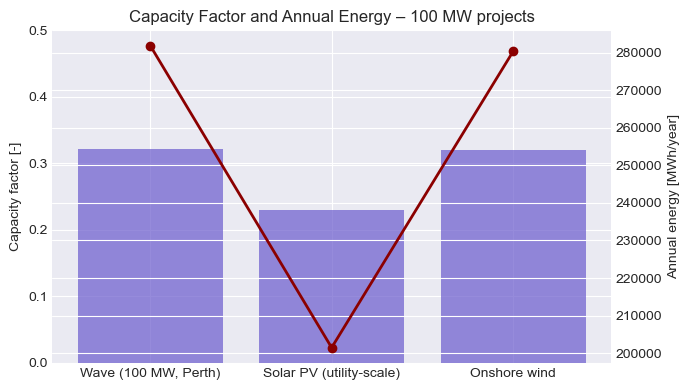

In [16]:
fig, ax1 = plt.subplots(figsize=(7, 4))

ax1.bar(results_df["Technology"], results_df["Capacity factor"],
        color="slateblue", alpha=0.7)
ax1.set_ylabel("Capacity factor [-]")
ax1.set_ylim(0, 0.5)

ax2 = ax1.twinx()
ax2.plot(results_df["Technology"], results_df["Annual energy [MWh/year]"],
         color="darkred", marker="o", linewidth=2, label="Annual energy")
ax2.set_ylabel("Annual energy [MWh/year]")

plt.title("Capacity Factor and Annual Energy – 100 MW projects")
plt.xticks(rotation=20, ha="right")
fig.tight_layout()
plt.show()

## 5. Recommendation

Using the Perth WEC dataset, I estimated a capacity factor of about **32%** for the wave energy farm. When this capacity factor is scaled to a 100 MW wave project and combined with high capital and operating costs, the resulting LCOE (≈205 USD/MWh) is much higher than for utility‑scale solar PV (≈54 USD/MWh) and onshore wind (≈69 USD/MWh) under the assumptions in this notebook. Solar PV and onshore wind therefore appear to be the most financially attractive options for adding 100 MW of new renewable capacity near Perth, given current technology maturity and cost levels.

Wave energy could become competitive under several conditions: (i) substantial reductions in CAPEX through technology learning and economies of scale, (ii) lower perceived risk and thus a lower discount rate, and (iii) targeted policy support such as grants, contracts for difference, or carbon pricing that rewards its potential system benefits. My simple financial model does not capture grid integration costs, resource uncertainty, degradation, market price volatility, system‑level reliability benefits, or environmental and social impacts, so a full decision would require a broader techno‑economic assessment. However, within the scope of this lab, solar PV and onshore wind are clearly the lowest‑cost choices.

---

### Questions?

**Dr. Eyuphan Koc**  
eyuphan.koc@bogazici.edu.tr